# 1. Import Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import torch

from skimage import measure
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Set Random Seed

In [3]:
torch.manual_seed(3)

## If needed unzip dataset

In [4]:
import zipfile
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

# 2. Define create databunch function (will make life easier later)

In [5]:
def create_db(size_frac, bs, split_pct=0.2):
    size = src_size//size_frac  # use smaller image sizes for to deal with memory issues
    bs = bs
    data = (SegmentationItemList.from_folder(path_img)  # gather images from image path
              .split_by_rand_pct(split_pct)  # randomly split into train and validation sets
              .label_from_func(get_y_fn, classes=codes)  # gather labels using function get_y_fn
              .transform(get_transforms(flip_vert=True, max_warp=None), tfm_y=True, size=size)  # perfrom data augmentation
              .databunch(bs=bs)  # create databunch object
              .normalize())  # normalize data based on ImageNet
    return data

# 3. Define Path to Dataset

In [6]:
path = Path('dataset/dataset/good')
path.ls()

[PosixPath('dataset/dataset/good/train_x'),
 PosixPath('dataset/dataset/good/test_x'),
 PosixPath('dataset/dataset/good/test_y_png'),
 PosixPath('dataset/dataset/good/train_y_png'),
 PosixPath('dataset/dataset/good/test_y'),
 PosixPath('dataset/dataset/good/train_y')]

# 4. Define Label and Image Paths

In [7]:
path_lbl = path/'train_y_png'
path_img = path/'train_x'

In [8]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('dataset/dataset/good/train_x/L2_301c09214b1fddfcdbc968e410ede74f_2312.jpg'),
 PosixPath('dataset/dataset/good/train_x/L2_180f42204af650d3790220c5ee59864e.jpg'),
 PosixPath('dataset/dataset/good/train_x/L2_356455cd36cadb82b5ab5ef4554d54f9.jpg')]

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('dataset/dataset/good/train_y_png/L2_989e54bafe3707276fc532ca1965a6ae.png'),
 PosixPath('dataset/dataset/good/train_y_png/L2_68e2a9921edc284d34abfd98f8ee36c3.png'),
 PosixPath('dataset/dataset/good/train_y_png/L2_898ab47c747fb0292a2d6fd8a98ec786.png')]

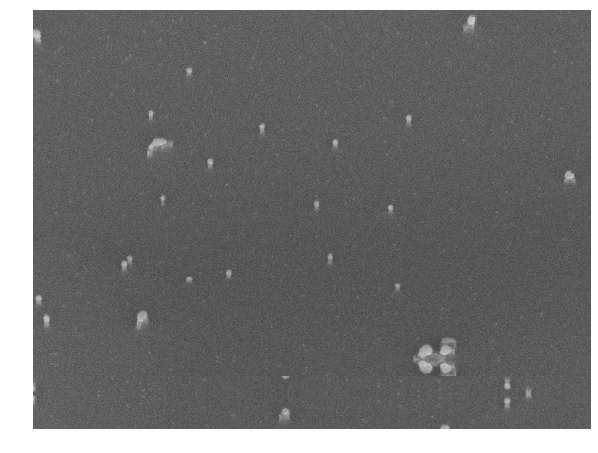

In [10]:
img_f = fnames[6]
img = open_image(img_f)
img.show(figsize=(10, 10))

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

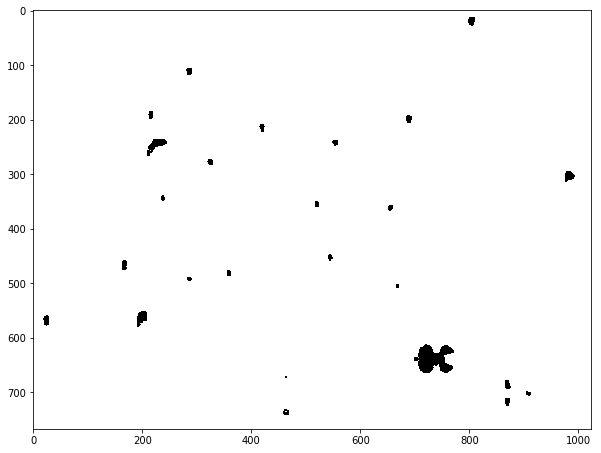

In [12]:
lbl_f = get_y_fn(img_f)
lbl = open_image(lbl_f)
lbl = (lbl.data)*255
lbl = lbl.numpy().transpose(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(lbl)

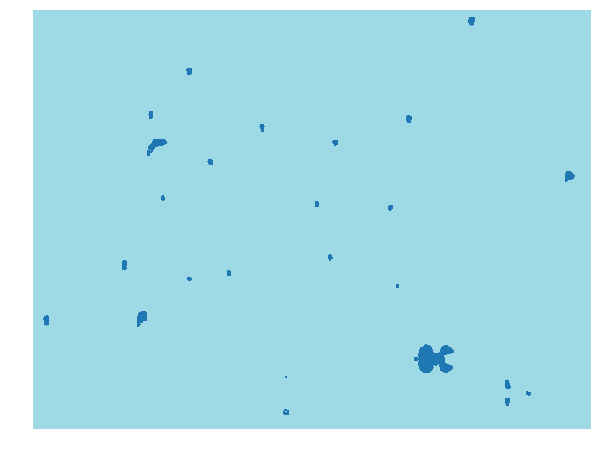

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10, 10), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 768, 1024]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]))

In [15]:
codes = np.array(['background', 'particle'], dtype = '<U17'); codes

array(['background', 'particle'], dtype='<U17')

# 4. Create Databunch

In [17]:
data = create_db(4, 8)

## Show Training Images with Labels Overlaid

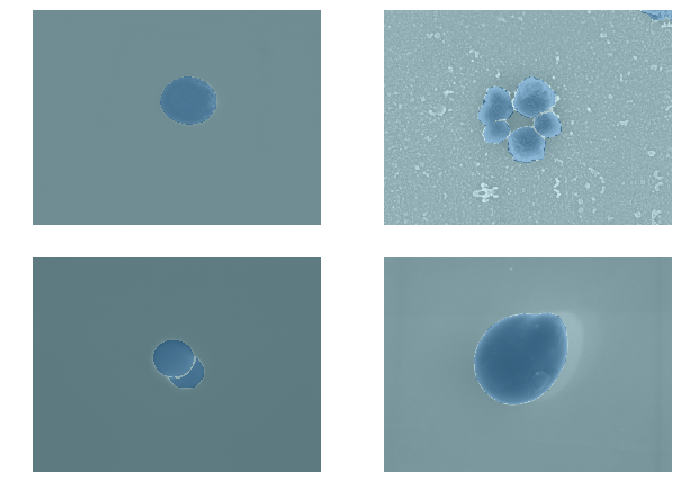

In [18]:
data.show_batch(2, figsize=(10, 7))

# 5. Create Model

In [19]:
learn = unet_learner(data, models.resnet34)

## Find Learning Rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


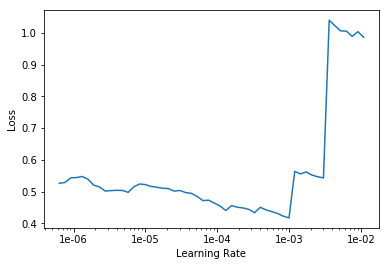

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
lr = 1e-4

## Perform initial fitting

In [23]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,time
0,0.470273,0.516937,00:06
1,0.404265,0.218423,00:06
2,0.319548,0.136721,00:05
3,0.271163,0.184764,00:05
4,0.250732,0.129388,00:06
5,0.215321,0.095567,00:06
6,0.182718,0.111599,00:06
7,0.162569,0.084665,00:06
8,0.140986,0.095009,00:06
9,0.129201,0.092610,00:06


In [24]:
learn.save('stage-1')

In [20]:
learn.load('stage-1');

## Freeze weights up to the second layer group and repeat above training process

In [21]:
learn.unfreeze()

In [22]:
learn.freeze_to(2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


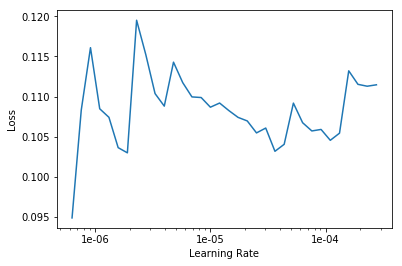

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lrs = slice(1e-5)

## Use more epochs for more thorough training

In [25]:
learn.fit_one_cycle(50, lrs)

epoch,train_loss,valid_loss,time
0,0.104886,0.039939,00:07
1,0.097011,0.041825,00:05
2,0.098739,0.045651,00:06
3,0.095779,0.046474,00:05
4,0.092518,0.045580,00:05
5,0.089749,0.040596,00:05
6,0.092931,0.049329,00:05
7,0.088980,0.039108,00:05
8,0.088979,0.044788,00:06
9,0.085440,0.041109,00:05


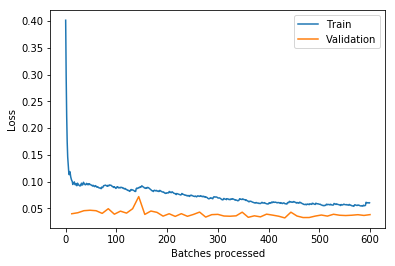

In [26]:
learn.recorder.plot_losses()

In [27]:
learn.save('stage-2')

In [20]:
learn.load('stage-2');

## Freeze weights up to first layer group and repeat training process

In [21]:
learn.unfreeze()
learn.freeze_to(1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


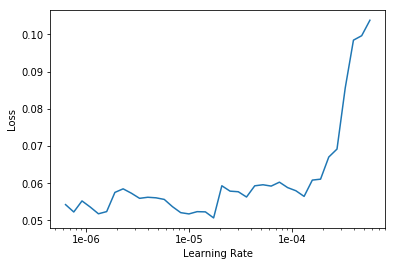

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lrs = slice(5e-6)

In [24]:
learn.fit_one_cycle(50, lrs)

epoch,train_loss,valid_loss,time
0,0.050368,0.032927,00:07
1,0.052423,0.033032,00:06
2,0.054184,0.033643,00:06
3,0.053298,0.033792,00:06
4,0.053321,0.033612,00:06
5,0.052498,0.032854,00:06
6,0.053690,0.032742,00:06
7,0.054574,0.032723,00:06
8,0.055907,0.031764,00:06
9,0.054110,0.032866,00:06


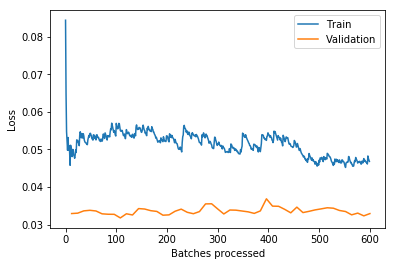

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.save('stage-3')

# 6. Perform Training with Larger Batch Size (8 --> 16)

In [16]:
data = create_db(4, 16)

In [17]:
learn = unet_learner(data, models.resnet34, metrics=dice)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


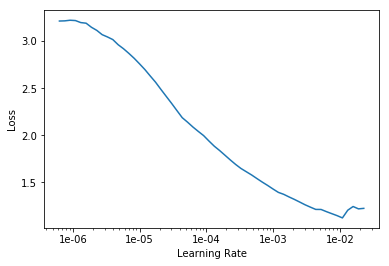

In [18]:
lr_find(learn)
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), wd=1e-4)

epoch,train_loss,valid_loss,dice,time
0,2.269438,0.706201,0.649577,00:09
1,1.393677,0.432613,0.889875,00:07
2,1.001768,0.359518,0.887749,00:08
3,0.798303,0.302946,0.895402,00:07
4,0.658726,0.258163,0.899162,00:07
5,0.545326,0.223655,0.912332,00:07
6,0.455345,0.149762,0.912929,00:08
7,0.388200,0.137324,0.919232,00:07
8,0.334269,0.151520,0.921795,00:07
9,0.292532,0.159760,0.920851,00:08


In [20]:
learn.save('stage-1_bs16')

In [18]:
learn.load('stage-1_bs16');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


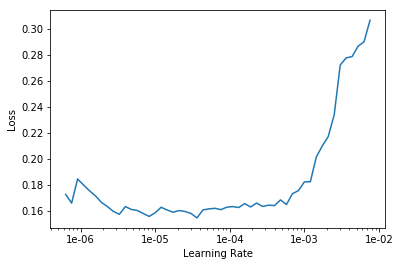

In [19]:
learn.unfreeze()
learn.freeze_to(2)
lr_find(learn)
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(50, slice(2e-5, 5e-5), wd=1e-1)

epoch,train_loss,valid_loss,dice,time
0,0.151907,0.081326,0.986830,00:09
1,0.150542,0.086297,0.985884,00:07
2,0.146145,0.068815,0.989875,00:07
3,0.143614,0.066526,0.990228,00:07
4,0.142742,0.082752,0.987230,00:08
5,0.139146,0.061217,0.990789,00:07
6,0.134941,0.057960,0.991248,00:07
7,0.129578,0.056872,0.991196,00:08
8,0.126879,0.052383,0.991715,00:08
9,0.131586,0.096152,0.983533,00:07


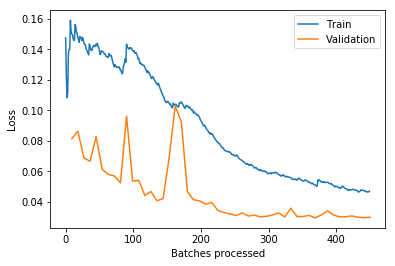

In [21]:
learn.recorder.plot_losses()

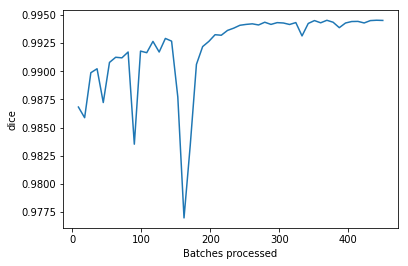

In [22]:
learn.recorder.plot_metrics()

In [24]:
learn.save('stage-2_bs16')

In [18]:
learn.load('stage-2_bs16');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


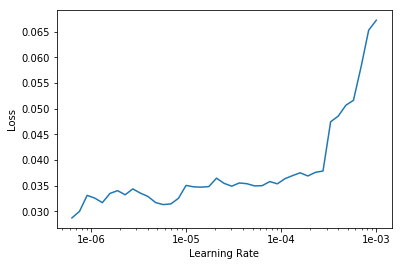

In [19]:
learn.unfreeze()
learn.freeze_to(1)
lr_find(learn)
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(50, slice(6e-6, 8e-6), wd=1e-1)

epoch,train_loss,valid_loss,dice,time
0,0.040632,0.024051,0.990208,00:09
1,0.040702,0.023941,0.990212,00:06
2,0.041173,0.024036,0.990245,00:06
3,0.038537,0.023740,0.990275,00:06
4,0.037757,0.023625,0.990197,00:06
5,0.036918,0.023422,0.990309,00:06
6,0.036329,0.023365,0.990354,00:06
7,0.035839,0.023802,0.990262,00:06
8,0.034353,0.023774,0.990303,00:06
9,0.034777,0.023731,0.990308,00:06


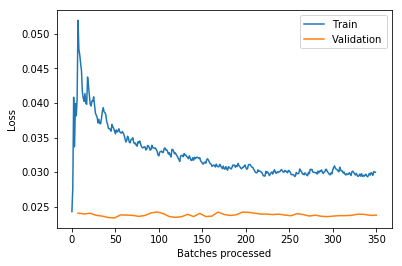

In [21]:
learn.recorder.plot_losses()

In [22]:
learn.save('stage-3_bs16')

# 7. Perform Training with Bigger Image Sizes but Smaller Batch Size

In [16]:
data = create_db(2, 6)

learn = unet_learner(data, models.resnet34, metrics = dice)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


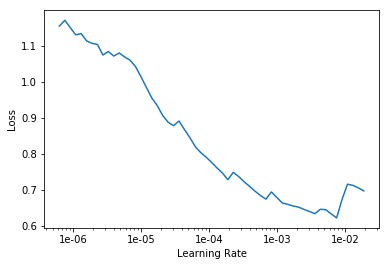

In [17]:
lr_find(learn)
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(10, slice(3e-5, 3e-4), wd=1e-3)

epoch,train_loss,valid_loss,dice,time
0,0.548362,0.504159,0.795432,00:22
1,0.411607,0.312047,0.904064,00:20
2,0.327925,0.201641,0.926595,00:20
3,0.263484,0.200815,0.920974,00:20
4,0.257824,0.239794,0.901191,00:20
5,0.252968,0.243536,0.915709,00:20
6,0.212545,0.358229,0.930308,00:20
7,0.200428,0.221440,0.918108,00:20
8,0.172397,0.165921,0.933215,00:20
9,0.144921,0.161902,0.938004,00:20


In [19]:
learn.save('stage-1_s2_bs6_03pct')

In [17]:
learn.load('stage-1_s2_bs6_03pct');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


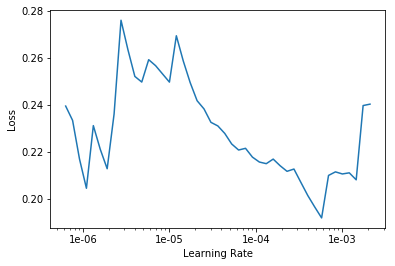

In [18]:
learn.unfreeze()
learn.freeze_to(2)
lr_find(learn)
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(40, slice(3e-5, 6e-5), wd=1)

epoch,train_loss,valid_loss,dice,time
0,0.209413,0.065483,0.988901,00:22
1,0.194029,0.091319,0.978223,00:20
2,0.182432,0.125674,0.970161,00:20
3,0.168846,0.095193,0.977625,00:20
4,0.156817,0.079416,0.983096,00:20
5,0.156170,0.145649,0.964856,00:20
6,0.151432,0.062556,0.988393,00:20
7,0.144010,0.063386,0.989199,00:20
8,0.142898,0.104897,0.975351,00:20
9,0.143490,0.108971,0.978136,00:20


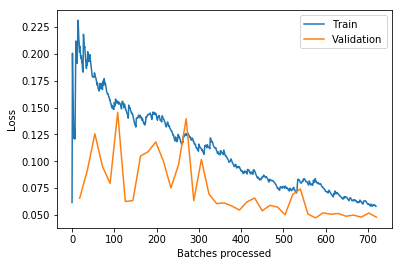

In [20]:
learn.recorder.plot_losses()

In [21]:
learn.save('stage-2_s2_bs6')

# 8. Determine Accuracy wrt Size Distributions

In [16]:
data = create_db(4, 16)

learn = unet_learner(data, models.resnet34, metrics = dice)

## Show Results of Model

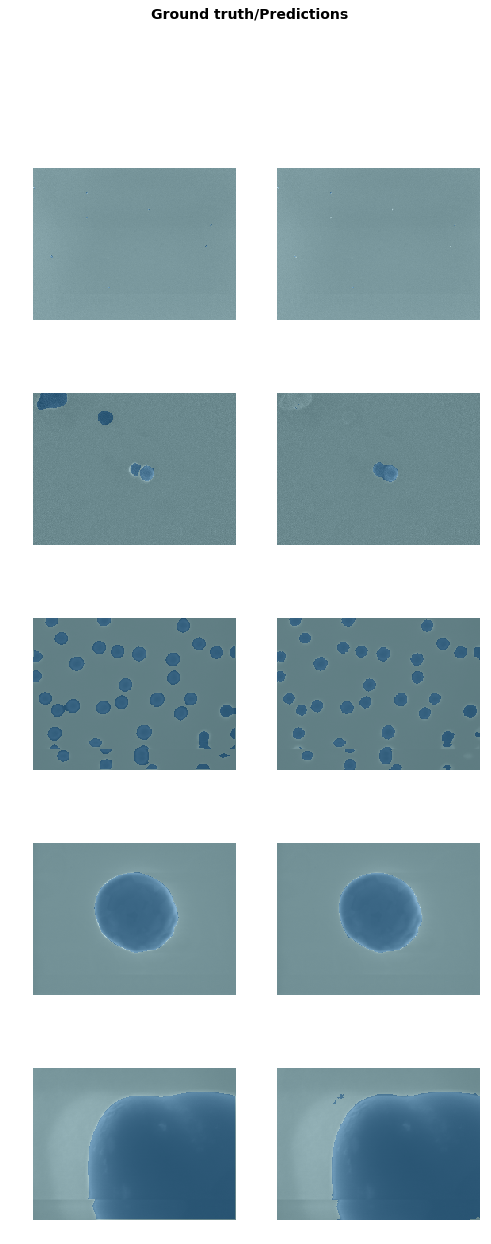

In [17]:
learn.load('stage-2_bs16');
learn.show_results()

## Grab Test Images and Labels

In [18]:
testpath_img = path/'test_x'
testpath_lbl = path/'test_y_png'

In [19]:
get_ytest_fn = lambda x: testpath_lbl/f'{x.stem}.png'

In [20]:
test_imgfiles = get_image_files(testpath_img)
test_lblfiles = get_image_files(testpath_lbl)

## Create Test Databunch

In [21]:
size = src_size//4
bs = 2
testdata = (SegmentationItemList.from_folder(testpath_img)
          .split_none()
          .label_from_func(get_ytest_fn, classes=codes)
          .transform(get_transforms(flip_vert=True, max_warp=None), tfm_y=True, size=size)
          .databunch(bs=bs)
          .normalize())

## Make Prediction on Test Image

Image (3, 192, 256)


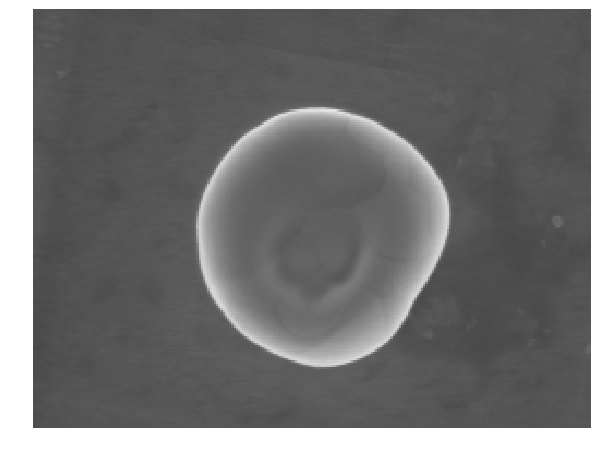

In [22]:
n = 9  # define which image in test databunch you want to look at
test_img = testdata.train_ds[n][0]
test_img.show(figsize = (10,10))
print(test_img)

In [23]:
pred = learn.predict(test_img)  # make prediction using trained model

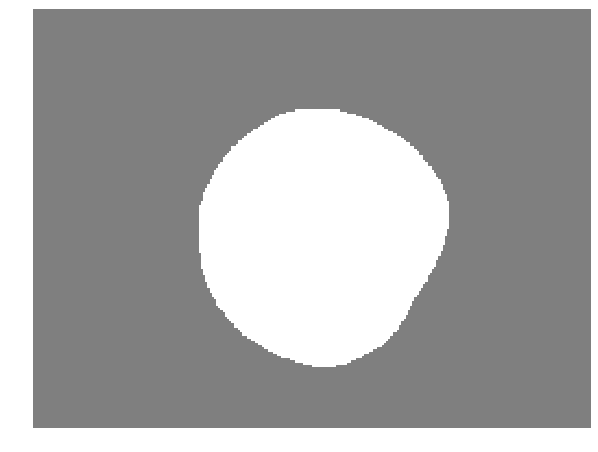

In [24]:
pred[0].show(figsize=(10,10), cmap='binary')

## Determine Size Distribution in Prediction

In [25]:
pred_data = pred[0].data
seg_labelled = measure.label(pred_data, background=255, connectivity=2)  # find all connected regions and give them a unique integer 
unique, counts = np.unique(seg_labelled, return_counts=True)  # determine identity and frequency of all unique integers

#find median and mean of unique integer frequency (ie. median and mean of size distribution)
print(f'Median = {np.median(counts[1:])}')
print(f'Mean = {np.mean(counts[1:])}')

Median = 10343.0
Mean = 10343.0


## Determine Size Distribution in Ground Truth Label

ImageSegment (1, 192, 256)


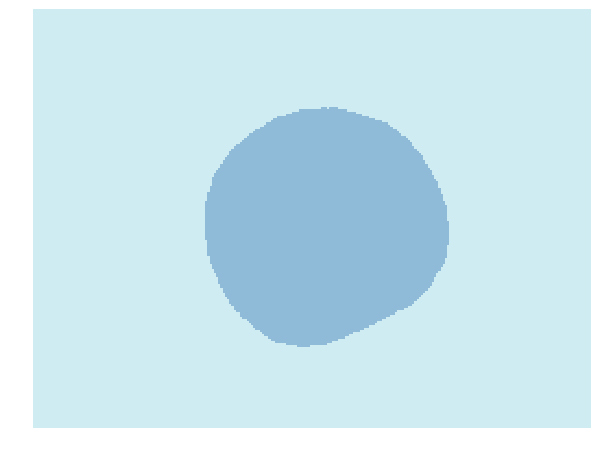

In [26]:
test_lbl = testdata.train_ds[n][1]
test_lbl.show(figsize = (10,10))
print(test_lbl)

In [27]:
testlbl_data = test_lbl.data
test_labelled = measure.label(testlbl_data, background = 255, connectivity = 2)
unique, counts = np.unique(test_labelled, return_counts=True)
print(f'Median = {np.median(counts[1:])}')
print(f'Mean = {np.mean(counts[1:])}')

Median = 9445.0
Mean = 9445.0


## Overlay Image and Prediction to Ensure Segmentation was Done Correctly

(-0.5, 255.5, 191.5, -0.5)

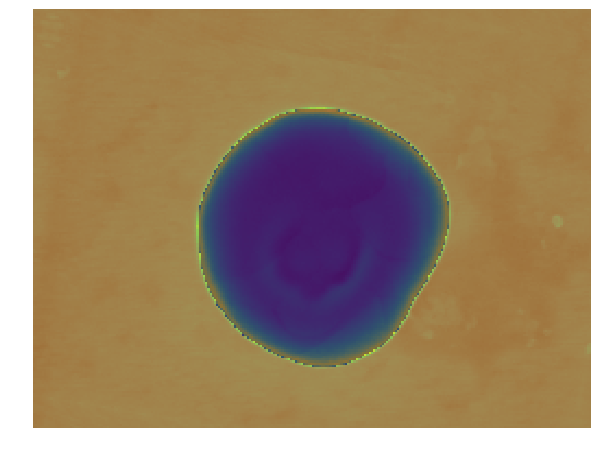

In [31]:
testimg_data = test_img.data[0]
pred_data = pred_data.reshape((size[0], size[1]))
testlbl_data = test_lbl.data.reshape((size[0], size[1]))

plt.figure(figsize=(10, 10))

plt.imshow(testimg_data)
plt.imshow(pred_data, alpha=0.5)
plt.axis('off')